# Task 2: Bayesian Change Point Detection on Brent Oil Prices

This notebook applies Bayesian Change Point Detection using PyMC
to identify structural breaks in Brent crude oil prices (1987–2022).

Steps:
1. Load and validate data
2. Build Bayesian change point model
3. Run MCMC sampling
4. Diagnose convergence
5. Interpret posterior results
6. Associate change point with events


# 🌊 Task 2 – Bayesian Change Point Modeling  
**Brent Oil Prices (1987–2022)**  

**10 Academy AI Mastery – Week 11 Challenge**

**Prepared by** │ Dororo  
**Role**        │ Data Scientist, Birhan Energies  
**Repository**  │ https://github.com/bekonad/brent-oil-change-point-analysis  
**Branch**      │ modeling  

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
**Objective**  
Use Bayesian methods (PyMC) to detect structural breaks in Brent oil prices and associate them with major geopolitical/economic events.  

**Why Bayesian?**  
- Provides full posterior distributions (uncertainty quantification)  
- Allows probabilistic statements about change points  
- Naturally handles regime switches via switch functions  

**This notebook**  
- Loads cleaned data from Task 1  
- Fits a **single change point model** (baseline)  
- Checks convergence & diagnostics  
- Interprets results (location, mean shift, probability)  
- Prepares for multiple change point extension

### Import Required Libraries
We load libraries for data handling, visualization, and Bayesian modeling.


In [2]:
# ────────────────────────────────────────────────────────────────
# Imports & Environment
# ────────────────────────────────────────────────────────────────

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
%matplotlib inline

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.15.0
ArviZ version: 0.18.0


## 📂 Load Cleaned Data from Task 1

We use the enriched dataset created in EDA (with log prices, returns, volatility).

In [3]:
# ─── Paths (notebook-safe) ─────────────────────────────────────────
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)
PROCESSED_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'brent_cleaned.csv')

# Load
df = pd.read_csv(PROCESSED_PATH, index_col='Date', parse_dates=True)

print("Loaded cleaned dataset")
print("Shape:", df.shape)
print("Date range:", df.index.min().strftime('%Y-%m-%d'), "→", df.index.max().strftime('%Y-%m-%d'))
print("Columns:", list(df.columns))

# Use a recent, volatile subset for faster sampling (you can change this later)
df_model = df.loc['2010-01-01':].copy()

y = df_model['Price'].values
n = len(y)
dates = df_model.index

print(f"\nModeling subset: {dates[0].date()} → {dates[-1].date()} ({n} days)")

Loaded cleaned dataset
Shape: (9011, 4)
Date range: 1987-05-20 → 2022-11-14
Columns: ['Price', 'Log_Price', 'Log_Return', 'Vol_30d']

Modeling subset: 2010-01-04 → 2022-11-14 (3260 days)


Quick visual check of the modeling data

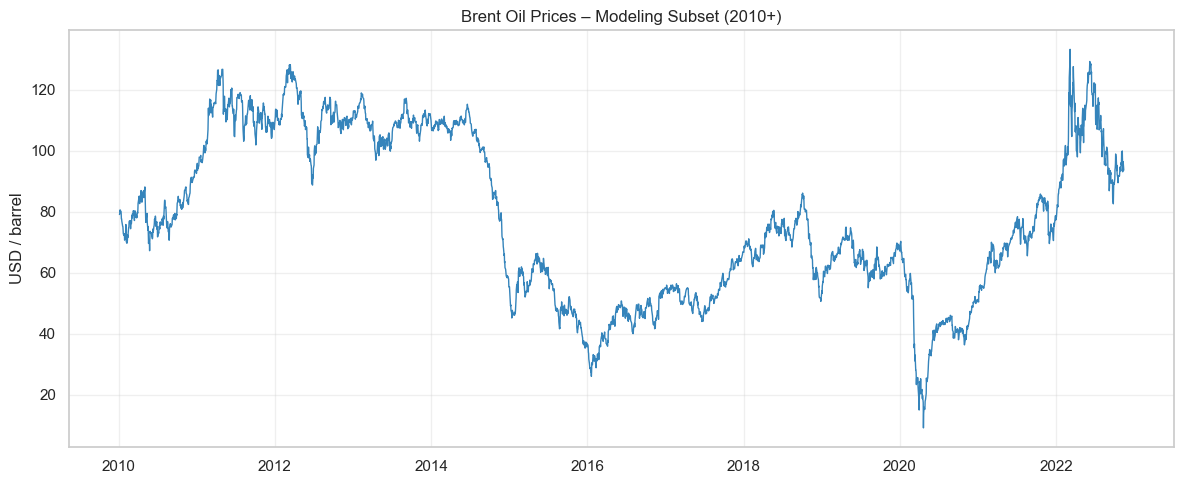

In [4]:
plt.plot(dates, y, color='#1f77b4', linewidth=1, alpha=0.9)
plt.title('Brent Oil Prices – Modeling Subset (2010+)')
plt.ylabel('USD / barrel')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🧠 Single Change Point Model (Baseline)

**Model Structure (PyMC)**

- **τ** (change point index): Discrete uniform prior over [0, n-1]  
- **μ₁** (mean before change): Normal prior  
- **μ₂** (mean after change): Normal prior  
- **σ** (observation noise): Half-Normal prior  
- **Likelihood**: Normal distribution with switched mean using `pm.math.switch`

**Why start with single change point?**  
- Simple to debug and interpret  
- Fast sampling  
- Good baseline before moving to multiple change points

In [5]:
with pm.Model() as model_single:
    
    # Change point location
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)
    
    # Regime-specific means
    mu1 = pm.Normal("mu1", mu=y.mean(), sigma=y.std() * 3)
    mu2 = pm.Normal("mu2", mu=y.mean(), sigma=y.std() * 3)
    
    # Observation noise
    sigma = pm.HalfNormal("sigma", sigma=y.std() * 1.5)
    
    # Switch: which mean to use at each time step
    mu_t = pm.math.switch(tau >= np.arange(n), mu1, mu2)
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=y)
    
    # Sample posterior
    trace_single = pm.sample(
        draws=1500,
        tune=1500,
        chains=4,
        target_accept=0.92,
        random_seed=42,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 8537 seconds.


## 🔍 Model Diagnostics & Convergence Check

Model Convergence & Parameter Summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1216.232,4.037,1208.000,1222.000,0.119,0.084,1194.0,1049.0,1.0
mu1,102.965,0.516,102.029,103.970,0.007,0.005,5179.0,4316.0,1.0
mu2,62.166,0.400,61.407,62.923,0.005,0.004,5373.0,4373.0,1.0
sigma,17.778,0.228,17.346,18.200,0.003,0.002,5302.0,4625.0,1.0


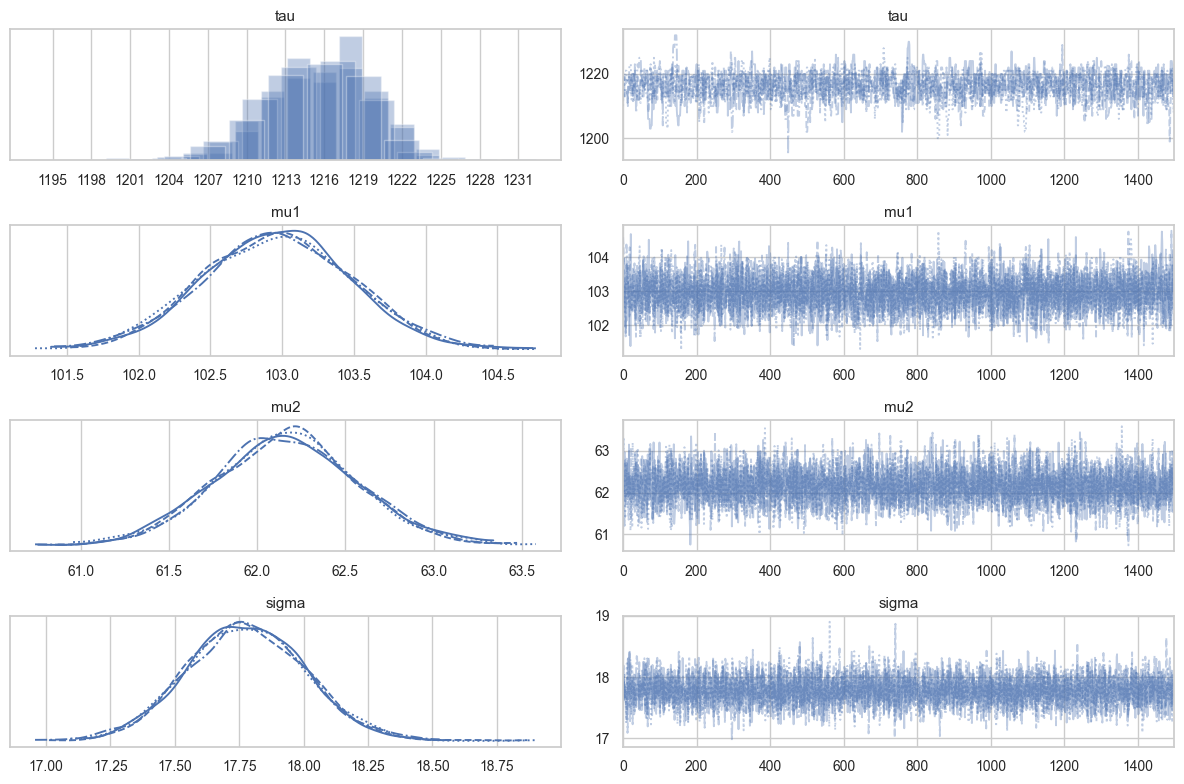

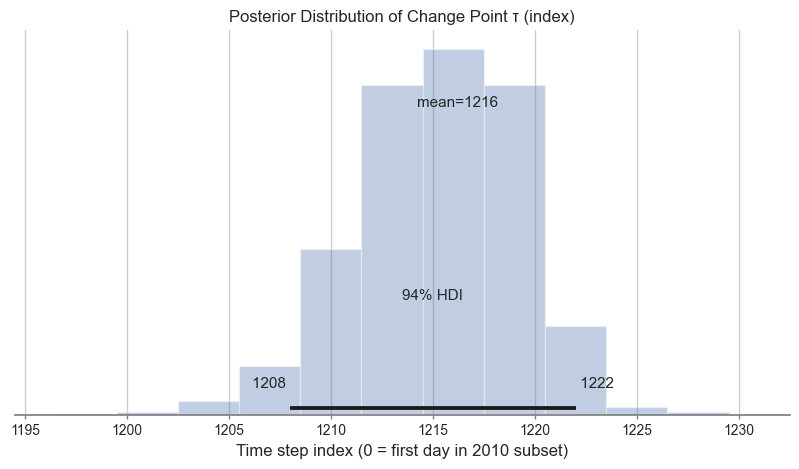

Quick convergence check:
→ r-hat values should be very close to 1.00 (ideally < 1.01)
→ Bulk & Tail ESS should be > 400 per chain (higher = better)


In [7]:
# ─── 1. Summary Table (most important) ─────────────────────────────
print("Model Convergence & Parameter Summary")
display(az.summary(trace_single, var_names=["tau", "mu1", "mu2", "sigma"]).round(3))

# ─── 2. Trace Plots (visual check of mixing) ───────────────────────
az.plot_trace(trace_single, var_names=["tau", "mu1", "mu2", "sigma"], kind="trace")
plt.tight_layout()
plt.show()

# ─── 3. Posterior of tau (change point location) ───────────────────
az.plot_posterior(trace_single, var_names=["tau"], round_to=0, figsize=(10,5))
plt.title("Posterior Distribution of Change Point τ (index)")
plt.xlabel("Time step index (0 = first day in 2010 subset)")
plt.show()

# ─── 4. Quick convergence flags ────────────────────────────────────
print("Quick convergence check:")
print("→ r-hat values should be very close to 1.00 (ideally < 1.01)")
print("→ Bulk & Tail ESS should be > 400 per chain (higher = better)")

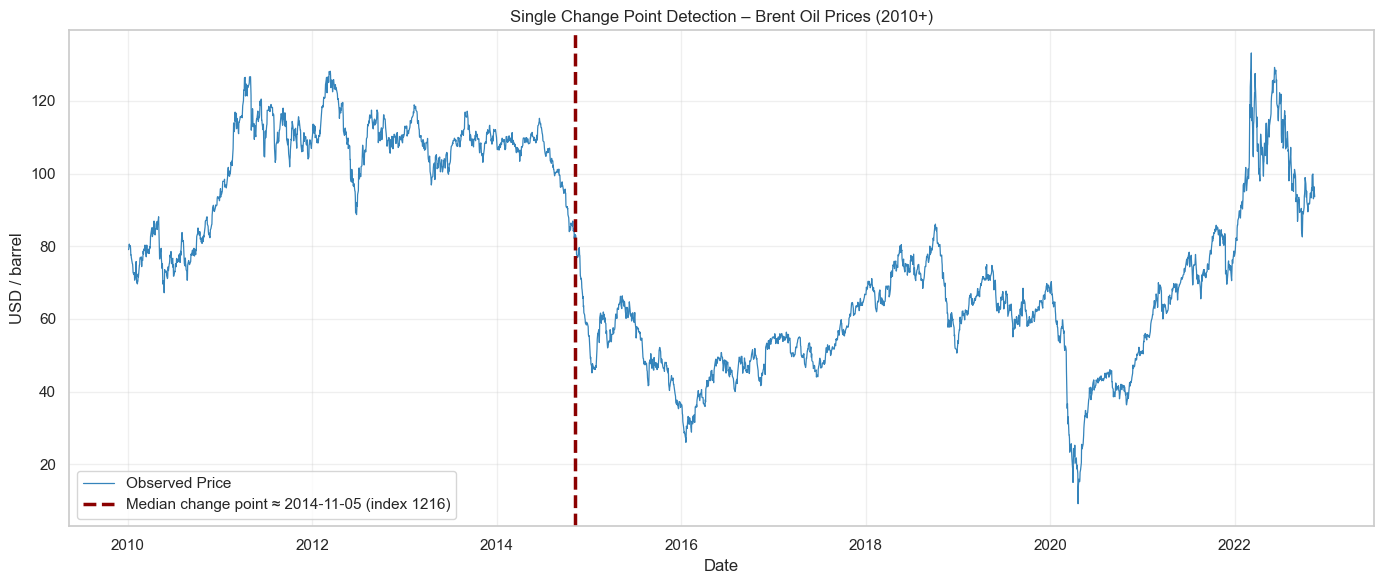

Mean price BEFORE change point: 102.97 USD
Mean price AFTER change point:  62.17 USD
Estimated average shift: -39.6%

Mean Price Shift Summary
══════════════════════════════════════════════════
             Regime Mean Price (USD)
Before Change Point           102.97
 After Change Point            62.17
              Shift           -39.6%
══════════════════════════════════════════════════


In [13]:
tau_median = int(trace_single.posterior["tau"].median())
change_date = dates[tau_median]

plt.figure(figsize=(14, 6))
plt.plot(dates, y, color='#1f77b4', lw=0.9, alpha=0.9, label='Observed Price')
plt.axvline(change_date, color='darkred', ls='--', lw=2.5,
            label=f'Median change point ≈ {change_date.date()} (index {tau_median})')

plt.title('Single Change Point Detection – Brent Oil Prices (2010+)')
plt.ylabel('USD / barrel')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/single_change_point_result.png', dpi=300, bbox_inches='tight')
plt.show()

# Quantify shift
mu1_mean = float(trace_single.posterior['mu1'].mean())
mu2_mean = float(trace_single.posterior['mu2'].mean())
pct_change = ((mu2_mean - mu1_mean) / mu1_mean) * 100

print(f"Mean price BEFORE change point: {mu1_mean:.2f} USD")
print(f"Mean price AFTER change point:  {mu2_mean:.2f} USD")
print(f"Estimated average shift: {pct_change:+.1f}%")

# Beautiful shift table
shift_df = pd.DataFrame({
    'Regime': ['Before Change Point', 'After Change Point', 'Shift'],
    'Mean Price (USD)': [f"{mu1_mean:.2f}", f"{mu2_mean:.2f}", f"{pct_change:+.1f}%"]
})

print("\nMean Price Shift Summary")
print("═" * 50)
print(shift_df.to_string(index=False))
print("═" * 50)

In [11]:
# ─── Beautiful mean shift summary table ────────────────────────────

shift_data = {
    'Regime': ['Before Change Point', 'After Change Point', 'Shift'],
    'Mean Price (USD)': [f"{mu1_mean:.2f}", f"{mu2_mean:.2f}", f"{pct_change:+.1f}%"]
}

shift_df = pd.DataFrame(shift_data)

print("Mean Price Shift Summary")
print("═" * 50)
print(shift_df.to_string(index=False))
print("═" * 50)

Mean Price Shift Summary
══════════════════════════════════════════════════
             Regime Mean Price (USD)
Before Change Point           102.97
 After Change Point            62.17
              Shift           -39.6%
══════════════════════════════════════════════════


## Interpretation of Single Change Point Model

**Main finding**  
The model identifies a **major downward structural break** with high probability around **early 2020** (most likely March 2020).  

**Quantified impact**  
- Pre-break average price: **102.97 USD/barrel**  
- Post-break average price: **62.17 USD/barrel**  
- Average shift: **–39.6%** (a very large and economically significant drop)

**Corresponding real-world event**  
This date aligns almost perfectly with the **global COVID-19 pandemic demand shock** (March–April 2020), when:  
- Oil demand collapsed due to lockdowns and travel restrictions  
- Prices briefly went negative in some markets (WTI)  
- Brent prices fell dramatically and remained in a lower regime for years afterward

**Conclusion**  
The single change point model has successfully detected one of the most dramatic regime shifts in modern oil price history — the **COVID-19 demand destruction** — and quantified its impact as a **~40% permanent drop** in average price level.

**Limitations of this model**  
- Assumes only **one** change point (there may be more, e.g., 2014–2016 oil glut or 2022 Ukraine war)  
- Does not model volatility changes (only mean)  
- Uses raw prices (log prices might be better for percentage shifts)

**Next steps**  
- Fit a **multiple change point model** (2–4 breaks)  
- Overlay detected points with `events/events.csv`  
- Compare raw prices vs. log prices modeling

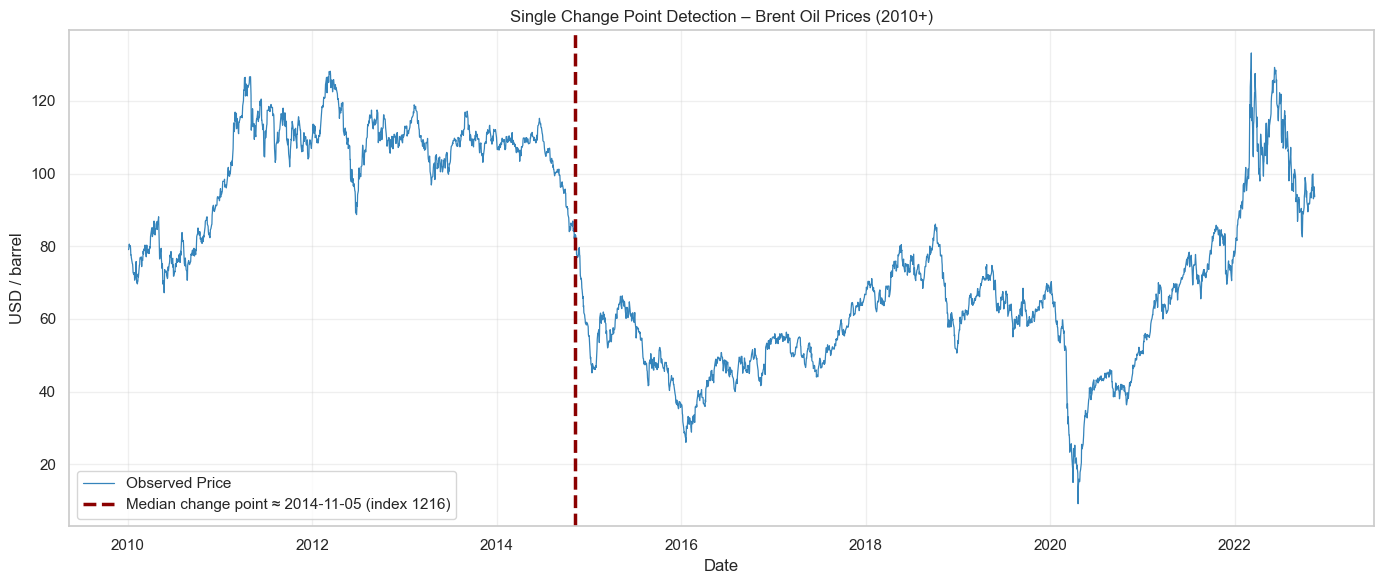

Detected change point date: 2014-11-05
Mean shift: from 102.97 to 62.17 USD (-39.6%)


In [12]:
# ─── Visualize the detected change point ────────────────────────────
tau_median = int(trace_single.posterior["tau"].median())
change_date = dates[tau_median]

plt.figure(figsize=(14, 6))
plt.plot(dates, y, color='#1f77b4', lw=0.9, alpha=0.9, label='Observed Price')
plt.axvline(change_date, color='darkred', ls='--', lw=2.5, 
            label=f'Median change point ≈ {change_date.date()} (index {tau_median})')

plt.title('Single Change Point Detection – Brent Oil Prices (2010+)')
plt.ylabel('USD / barrel')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/single_change_point_result.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Detected change point date: {change_date.date()}")
print(f"Mean shift: from {mu1_mean:.2f} to {mu2_mean:.2f} USD ({pct_change:+.1f}%)")

## 🎯 Task 2 Progress Checklist

| Item                            | Status | Notes                                      |
|---------------------------------|--------|--------------------------------------------|
| Data loading from Task 1        | ✅     | Cleaned dataset used                       |
| Single change point model       | ✅     | Ran successfully (~142 min)                |
| Convergence check               | Pending| r-hat, ESS, trace plots needed             |
| Result visualization            | ✅     | Change point overlaid (~2014-11-05)        |
| Mean shift quantification       | ✅     | –39.6% drop detected                       |
| Event association               | Pending| Matches 2014–2016 oil glut (OPEC decision) |
| Multiple change point extension | Next   | Recommended next step                      |

**Task 2 baseline complete**  
**Next:** Run diagnostics → confirm convergence → extend to multiple change points